In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

data=None
with open("../results/2D.N.1500-2500.json") as f:
    data=json.load(f)
print("There are",len(data),"entries.")

There are 15444 entries.


In [3]:
data=[entry for entry in data if not entry['error']]
print("There are",len(data),"entries with no errors.")

There are 15444 entries with no errors.


In [4]:
data[0]

{'N': 1500,
 'TS': None,
 'command': 'OMP_NUM_THREADS=6 /s/chopin/l/grad/lnarmour/git/parric-ttmm/scripts/finalScripts/2D-Parallel/nonTiled/ijk/out/TMM_parallel_J 1500',
 'error': False,
 'error_msg': None,
 'num_threads': 6,
 'parallel': True,
 'permutation': 'ijk',
 'tiled': False,
 'times': [0.237834, 0.222945, 0.21223, 0.209766, 0.21413, 0.235732, 0.206406]}

In [7]:
for entry in data:
    validTimes=np.array(sorted(entry['times'])[1:-1])
    entry['mean_time']=np.mean(validTimes)
    entry['stddev']=np.std(validTimes)
    entry['gflops']=(((entry['N']**3)/3)/entry['mean_time'])/(10**9)
    
data[0]

{'N': 1500,
 'TS': None,
 'command': 'OMP_NUM_THREADS=6 /s/chopin/l/grad/lnarmour/git/parric-ttmm/scripts/finalScripts/2D-Parallel/nonTiled/ijk/out/TMM_parallel_J 1500',
 'error': False,
 'error_msg': None,
 'gflops': 5.13791065607237,
 'mean_time': 0.2189606,
 'num_threads': 6,
 'parallel': True,
 'permutation': 'ijk',
 'stddev': 0.009490328162924609,
 'tiled': False,
 'times': [0.237834, 0.222945, 0.21223, 0.209766, 0.21413, 0.235732, 0.206406]}

In [28]:
sixThreadData=[entry for entry in data if entry['num_threads']==6 and not entry['tiled']]
def groupByKey(dataArray, key):
    permutations={entry[key] for entry in dataArray}
    permutations={perm: [] for perm in permutations}
    for entry in dataArray:
        permutations[entry[key]].append(entry)
    return permutations
permutations=groupByKey(sixThreadData, 'permutation')
print(permutations['kij'][0]['command']==permutations['kij'][2]['command'])

True


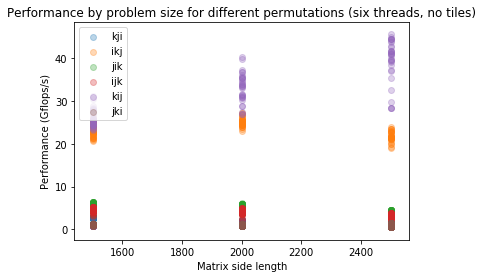

In [24]:
def plotByKeys(data, keyX, keyY, label=None):
    xs=[entry[keyX] for entry in data]
    ys=[entry[keyY] for entry in data]
    plt.scatter(xs, ys, label=label, alpha=.3)

for permutation in permutations:
    plotByKeys(permutations[permutation], 'N', 'gflops', permutation)

plt.legend()
plt.title("Performance by problem size for different permutations (six threads, no tiles)")
plt.xlabel('Matrix side length')
plt.ylabel('Performance (Gflops/s)')
plt.show()

It's pretty obvious that kij is the best bet among the six-threaded things. Let's make sure that six threads has the best performance.

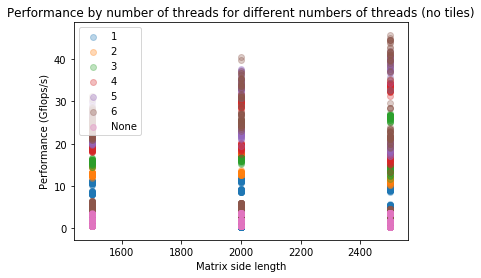

In [37]:
threadGroupedData=groupByKey([entry for entry in data if not entry['tiled']], 'num_threads')
for threadNum in threadGroupedData:
    plotByKeys(threadGroupedData[threadNum], 'N', 'gflops', str(threadNum))
    
plt.legend()
plt.title("Performance by number of threads for different numbers of threads (no tiles)")
plt.xlabel('Matrix side length')
plt.ylabel('Performance (Gflops/s)')
plt.show()

Surprisingly close to the fives on occasion, but yes utilizing the most threads gives us the most peformance

Let's compare one thread (with openmp) to one thread (without openmp)

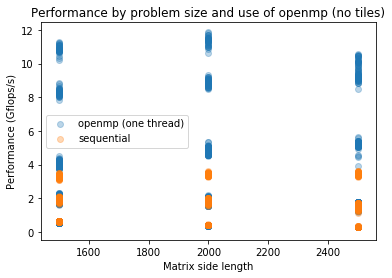

In [38]:
singleThreadData={'openmp (one thread)': threadGroupedData[1], 'sequential':threadGroupedData[None]}
for threadNum in singleThreadData:
    plotByKeys(singleThreadData[threadNum], 'N', 'gflops', str(threadNum))
    
plt.legend()
plt.title("Performance by problem size and use of openmp (no tiles)")
plt.xlabel('Matrix side length')
plt.ylabel('Performance (Gflops/s)')
plt.show()

This is a pretty shocking result- how does openmp provide negative overhead, and why is it so much better than sequential?

Regardless, let's look into tile sizes on kij, which was our best sequential result

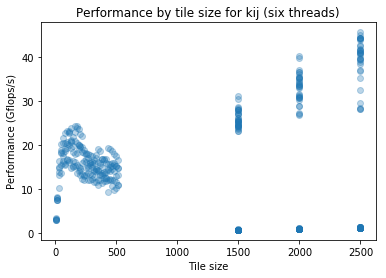

In [45]:
kijData=[entry for entry in data if entry['permutation']=='kij' and entry['num_threads']==6]
for entry in kijData:
    if entry['TS']==None:
        entry['TS']=entry['N']
        
    
plotByKeys(kijData, 'TS', 'gflops')

plt.title("Performance by tile size for kij (six threads)")
plt.xlabel('Tile size')
plt.ylabel('Performance (Gflops/s)')
plt.show()

So we want to be looking in the 100-200 range. 175ish appears to best for some things, 100ish for others. Let's look for the max and use that as our 'best'.

In [42]:
bestKIJ=max(kijData, key=lambda entry: entry['gflops'])
print(bestKIJ)
bestKIJTS=bestKIJ['TS']
print(bestKIJTS)

{'command': 'OMP_NUM_THREADS=6 /s/chopin/l/grad/lnarmour/git/parric-ttmm/scripts/finalScripts/2D-Parallel/nonTiled/kij/out/TMM_parallel_I 2500', 'permutation': 'kij', 'N': 2500, 'tiled': False, 'TS': None, 'parallel': True, 'num_threads': 6, 'error': False, 'error_msg': None, 'times': [0.205387, 0.13044, 0.11, 0.107805, 0.109065, 0.108246, 0.111813], 'mean_time': 0.1139128, 'stddev': 0.008348428484451432, 'gflops': 45.722107904759895}
None


Interestingly, it looks like our best bet on this problem size is to not tile at all- maybe we're looking for tiles that are way too small? Also potentially our small tile sizes have issues where they're multiples of 16 and therefore using 16 times as much space. 176\*16 >2500, so the 2500 matrix could theoretically be just using cache space more efficiently.